# Plotting the training log.

[i] Loaded CSV: C:\Users\Work\Desktop\Github_repo\cell_browser\data\nucleus-ae\training_log.csv
[i] Columns found: ['epoch', 'loss', 'mse', 'val_loss', 'val_mse']


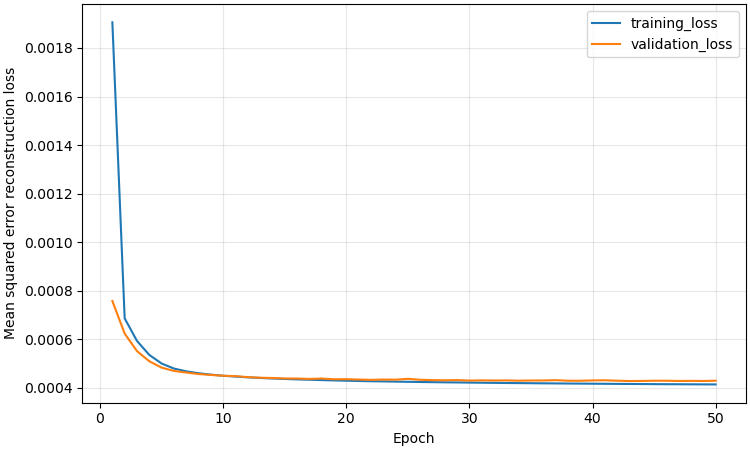

In [1]:
#| label: ae1m-loss-plot
import os, csv
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Optional interactive backend (ok to keep)
try:
    from IPython import get_ipython
    ip = get_ipython()
    if ip is not None:
        ip.run_line_magic("matplotlib", "widget")
except Exception:
    pass

# Point to the DIRECTORY that contains training_log.csv
LOG_PATH = Path(r"C:\Users\Work\Desktop\Github_repo\cell_browser\data\nucleus-ae")

def _pick_csv_from_dir(d: Path) -> Path:
    """Return <dir>/training_log.csv or raise if missing."""
    p = d / "training_log.csv"
    if not p.is_file():
        raise FileNotFoundError(f"'training_log.csv' not found in: {d}")
    return p

def _resolve_log_path(p: Path) -> Path:
    """
    Only allow:
      - a directory containing training_log.csv
      - OR the file itself named exactly training_log.csv
    """
    if p.is_dir():
        return _pick_csv_from_dir(p)
    if p.is_file():
        if p.name != "training_log.csv":
            raise FileNotFoundError(f"Expected 'training_log.csv', got: {p.name}")
        return p
    raise FileNotFoundError(f"Path does not exist: {p}")

def load_log(path_like):
    csv_path = _resolve_log_path(Path(path_like))
    with open(csv_path, "r", newline="", encoding="utf-8-sig") as f:
        reader = csv.DictReader(f)
        rows = list(reader)
        fieldnames = reader.fieldnames or []

    if not rows:
        raise ValueError(f"CSV is empty: {csv_path}")

    def col(names):
        """Try multiple possible column names; return first match as float array or None."""
        for name in (names if isinstance(names, (list, tuple)) else [names]):
            if name in fieldnames:
                vals = []
                for r in rows:
                    v = r.get(name, "")
                    try:
                        vals.append(float(v))
                    except Exception:
                        vals.append(np.nan)
                return np.asarray(vals, dtype=float)
        return None

    # Common variants
    epoch    = col(["epoch"])
    loss     = col(["loss", "mse", "train_loss", "training_loss"])
    val_loss = col(["val_loss", "val_mse", "validation_loss"])

    epochs = (epoch.astype(int) + (0 if epoch is not None and epoch.min() >= 1 else 1)) \
             if epoch is not None else np.arange(1, len(rows) + 1)

    print(f"[i] Loaded CSV: {csv_path}")
    print(f"[i] Columns found: {fieldnames}")
    return epochs, loss, val_loss

# ----- load + plot -----
epochs, loss, val_loss = load_log(LOG_PATH)

fig, ax = plt.subplots(figsize=(7.5, 4.5), constrained_layout=True)
plotted = False
if loss is not None:
    ax.plot(epochs, loss, label="training_loss"); plotted = True
if val_loss is not None:
    ax.plot(epochs, val_loss, label="validation_loss"); plotted = True

if not plotted:
    raise ValueError("No recognizable loss columns found "
                     "(looked for: loss/mse/train_loss/training_loss and val_loss/val_mse/validation_loss).")

ax.set_xlabel("Epoch")
ax.set_ylabel("Mean squared error reconstruction loss")
ax.grid(True, alpha=0.3)
ax.legend()
fig.canvas.toolbar_visible = True
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
plt.show()
